In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [3]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


We want to guess/predict if the wine falls on the lower end or higher end of the points spectrum based on the description.

So we're going to focus on the description and points column

In [4]:
df.shape

(129971, 6)

In [5]:
df.dropna(subset=['points', "description"], inplace=True)

In [6]:
df.shape

(129971, 6)

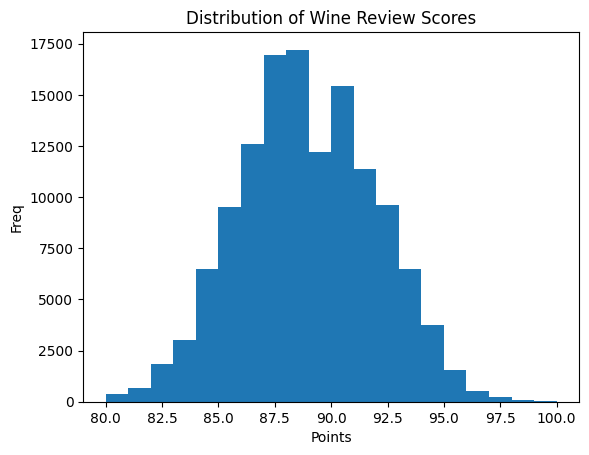

In [7]:
plt.hist(df.points, bins=20)
plt.title("Distribution of Wine Review Scores")
plt.ylabel("Freq")
plt.xlabel("Points")
plt.show()

In [8]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [9]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

c:\Users\luthf\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [10]:
train.shape, val.shape, test.shape

((103976, 2), (12997, 2), (12998, 2))

In [11]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [12]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

Using tensorflow hub (embedded ml model)

Model

In [21]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

hub_layer(list(train_data)[0][0])

model = tf.keras.Sequential([
     tf.keras.layers.Lambda(lambda x: hub_layer(x)),
     tf.keras.layers.Dense(16, activation='relu'),
     # tf.keras.layers.Dropout(0.4),  #For overfitting prevention
      tf.keras.layers.Dense(16, activation='relu'),
     # tf.keras.layers.Dropout(0.4),
     tf.keras.layers.Dense(1, activation='sigmoid')
])

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics =['accuracy'])

In [23]:
model.evaluate(train_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3780 - loss: 0.7259


[0.7255009412765503, 0.379366397857666]

In [24]:
model.evaluate(valid_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3800 - loss: 0.7261


[0.7260628342628479, 0.3790874779224396]

In [25]:
history = model.fit(train_data, validation_data=valid_data, epochs=10)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5418 - loss: 0.6867 - val_accuracy: 0.6245 - val_loss: 0.6519
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6297 - loss: 0.6425 - val_accuracy: 0.6779 - val_loss: 0.6063
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6789 - loss: 0.6003 - val_accuracy: 0.6945 - val_loss: 0.5811
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6981 - loss: 0.5774 - val_accuracy: 0.7022 - val_loss: 0.5713
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7029 - loss: 0.5690 - val_accuracy: 0.7061 - val_loss: 0.5674
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7060 - loss: 0.5671 - val_accuracy: 0.7099 - val_loss: 0.5645
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7095 - loss: 0.5640 - val_accuracy: 0.7101 - val_loss: 0.5625
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7096 - loss: 0.5621 - val_accuracy: 0.

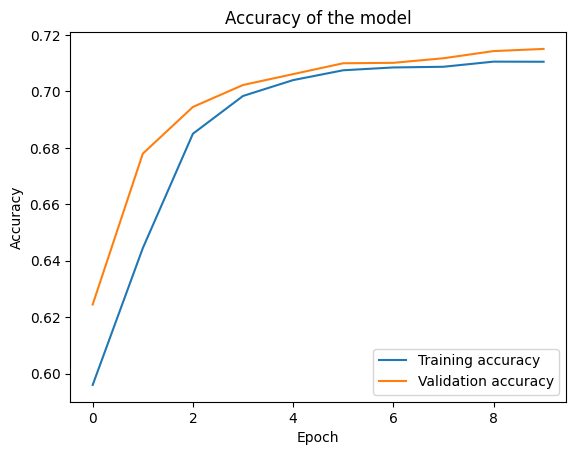

In [26]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy of the model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

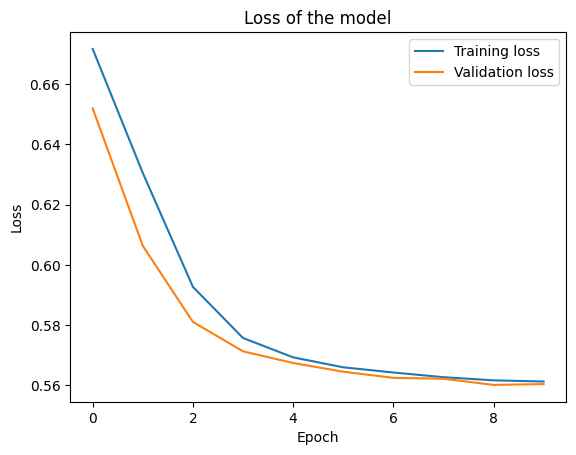

In [27]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss of the model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## LSTM

In [35]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label:text))

In [36]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [44]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim= len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    # tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [45]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics =['accuracy'])

In [46]:
model.evaluate(train_data)

102/102 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.4023 - loss: 0.6939


[0.6939202547073364, 0.4026794731616974]

In [47]:
model.evaluate(valid_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.3959 - loss: 0.6940


[0.6939590573310852, 0.4011695086956024]

In [48]:
history = model.fit(train_data, validation_data=valid_data, epochs=10)

Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 0.6477 - loss: 0.6220 - val_accuracy: 0.8305 - val_loss: 0.3769
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 0.8332 - loss: 0.3658 - val_accuracy: 0.8347 - val_loss: 0.3596
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.8474 - loss: 0.3401 - val_accuracy: 0.8440 - val_loss: 0.3463
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - accuracy: 0.8481 - loss: 0.3343 - val_accuracy: 0.8443 - val_loss: 0.3460
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 0.8492 - loss: 0.3298 - val_accuracy: 0.8436 - val_loss: 0.3441
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 155ms/step - accuracy: 0.8516 - loss: 0.3250 - val_accuracy: 0.8437 - val_loss: 0.3434
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.8550 - loss: 0.3210 - val_accuracy: 0.8384 - val_loss: 0.3502
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.8539 - loss: 0

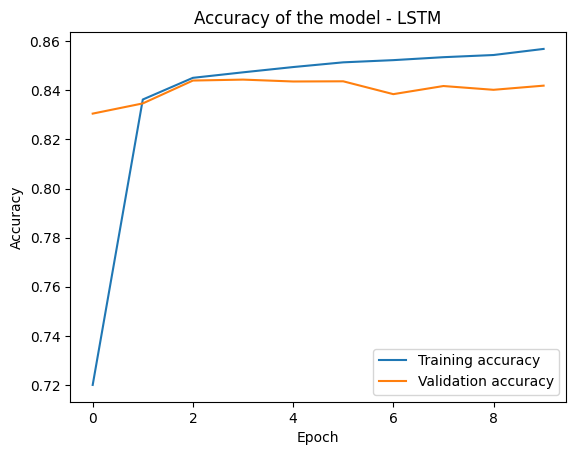

In [49]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy of the model - LSTM')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

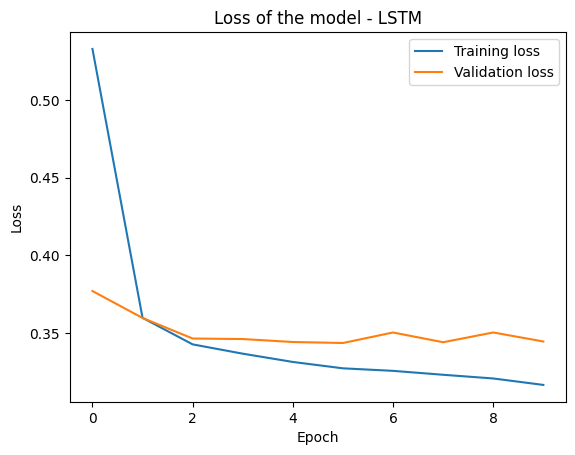

In [50]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Loss of the model - LSTM')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [51]:
model.evaluate(test_data)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.8360 - loss: 0.3665


[0.36200007796287537, 0.8361286520957947]